In [1]:
from time import gmtime, strftime
from tqdm import tqdm
import importlib

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
import IPython
# %matplotlib qt
import seaborn as sns

# import stream_generator
import learning_models
from datasets.data_loader import load_dataset
import temporal_model_inference
from baselines_v2 import kswin_reg
from baselines_v2 import naive_reg
from baselines_v2 import adwin_reg
import msmsa_v3 as msmsa


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


import neural_net_base_learner
# import wandb
import os
from utility.utilities import Logger, Plotter
from utility.sample import Sample

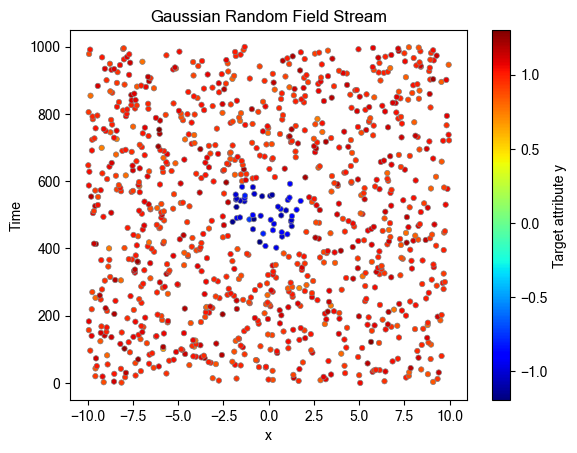

In [171]:




def generate_2d_gaussian_random_field(num_points, scale):
    # Sample x and y randomly
    x = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Compute the distance matrix
    d = np.sqrt((x[:, None] - x[None, :])**2 + (t[:, None] - t[None, :])**2)
    
    # Define the covariance function
    covariance_func = np.exp(-d**2 / (2 * scale**2))
    
    # Generate the random field
    mean = np.zeros(num_points)
    y = np.random.multivariate_normal(mean, covariance_func)
    y = y + np.random.normal(0, .2, num_points)
    return x, t, y

def generate_2_class_field(num_points):
    # Sample x and y randomly
    x = np.random.uniform(-10, 10, num_points)
    # t = np.random.uniform(0, 1, num_points)
    t = np.arange(num_points)
    
    # Generate the random field
    y = np.ones(num_points)
    for i in range(num_points):
        if -2 < x[i] < 2 and  400 < t[i] < 600:
        # if x[i]+t[i] > 1:
            y[i] = -1

    y = y + np.random.normal(0, .1, num_points)
    return x, t, y

def generate_2d_abrupt_drift_field(num_points):
    # Sample x and y randomly
    x = np.random.uniform(1, 2, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Generate the random field
    y = np.ones(num_points)
    for i in range(num_points):
        if t[i] > 0.5 and x[i] < 1:
        # if t[i] > 0.5:
        # if x[i]+t[i] > 1:
            y[i] = -1
            # print(y[i],i)
    y = y + np.random.normal(0, 0.3, num_points)
    return x, t, y


# Parameters
num_points = 500  # Number of points to sample
scale = 0.1  # Scale of the correlation

# Generate field
# x1, t1, y1 = generate_2d_gaussian_random_field(num_points, scale)
x2, t2, y2 = generate_2_class_field(int(num_points/0.5))
# x2, t2, y2 = generate_2d_gaussian_random_field(num_points, scale)


# # combine the data into one dataset
# x = np.concatenate((x1, x2+1))
# t = np.concatenate((t1, t2))
# y = np.concatenate((y1, y2))


# x, t, y = generate_2d_abrupt_drift_field(num_points)



# x = x1
# t = t1
# y = y1

x = x2
t = t2
y = y2

num_samples = len(x)
# Make a stream of samples
stream = []
for i in range(num_samples):
    stream.append((x[i], y[i], t[i], None))
# sort samples in the stream by time
stream.sort(key=lambda sample: sample[2])

%matplotlib qt
# Create a contour plot
# plt.figure(figsize=(5, 4))
# plt.tricontourf(x, t, y, levels=20, cmap='viridis')
# plt.colorbar(label='Target attribute y')
vmin = min(y)
vmax = max(y)
# scatter plot using sns

# change the font to sans-serif


%matplotlib inline
# make a colorbar

plt.rcParams["font.family"] = "Microsoft Sans Serif"

plt.scatter(x, t, c=y, s=15, cmap='jet',vmin=vmin, vmax=vmax, edgecolor='gray', linewidth=0.5)
plt.colorbar(label='Target attribute y')


# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.title('Gaussian Random Field Stream')
plt.xlabel('x')
plt.ylabel('Time')
plt.show()


1


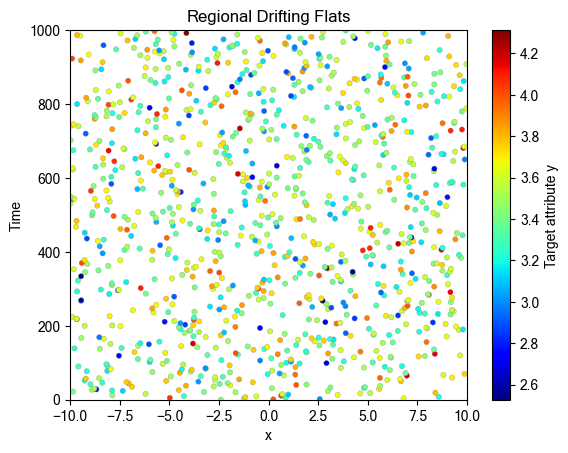

In [170]:
import stream_generator
%matplotlib inline
# reload stream_generator
importlib.reload(stream_generator)
synthetic_param = {'noise_var': .3, # [0, 1, 2, 3, 4, 5]
                    'stream_size': 1_000,
                    'drift_prob':0.001,
                    'dim': 1}

# seed = np.random.randint(0, 1000)
stream = stream_generator.regional_drift(synthetic_param, seed=None)
x = np.array([item[0] for item in stream]).squeeze()
y = np.array([item[1] for item in stream])
t = np.arange(len(x))
w = [item[2] for item in stream]
# drop the None values from w
w = [item for item in w if item[0] != -1]
print(len(w))


num_samples = len(x)
# Make a stream of samples
stream = []
for i in range(num_samples):
    stream.append((x[i], y[i], t[i], None))
# sort samples in the stream by time
stream.sort(key=lambda sample: sample[2])
vmin = min(y)
vmax = max(y)


# make a colorbar
plt.close('all')
plt.rcParams["font.family"] = "Microsoft Sans Serif"


w = w[1:]
# draw a rectangle to show the drift region using w where w[1] is t_start and w[2] is t_end w[3] x_start and w[4] x_end
for item in w:
    # get the jet color of the value item[5] with vmin and vmax
    color = plt.cm.jet((item[5]-vmin)/(vmax-vmin))
    plt.gca().add_patch(plt.Rectangle((item[3], item[1]), item[4]-item[3], item[2]-item[1], fill=True, edgecolor='gray', lw=1, alpha=0.2, facecolor=color))

plt.scatter(x, t, c=y, s=15, cmap='jet',vmin=vmin, vmax=vmax, edgecolor='gray', linewidth=0.2)
plt.colorbar(label='Target attribute y')



plt.xlim(-10, 10)
plt.ylim(0, 1000)
plt.title('Regional Drifting Flats')
plt.xlabel('x')
plt.ylabel('Time')
plt.show()

## Offline Naive Prediction

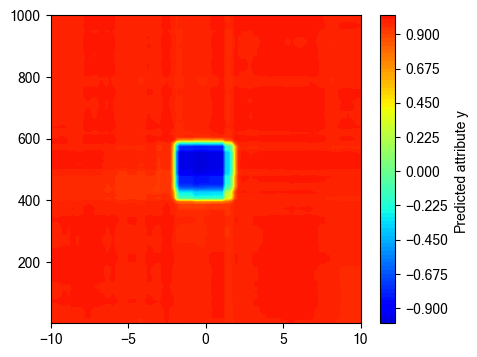

In [195]:
importlib.reload(temporal_model_inference)

%matplotlib inline
# online_model = dth.DTH(epsilon=0.9, prior=0.5)
# online_model.base_learner = neural_net_base_learner.RegressionNN(    hidden_layers=[50, 50, 50, 50, 50, 20, 10],
#                                                                 input_dim=2, 
#                                                                 output_dim=1,
#                                                                 dropout=0.05, 
#                                                                 learning_rate=0.1, 
#                                                                 epochs=200)
online_model = naive_reg.Naive()

online_model.base_learner = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1, bootstrap=True, max_samples=0.9, min_samples_leaf=10)

# online_model.base_learner = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=7))
# online_model.base_learner = RandomForestRegressor(n_estimators=20, max_depth=7, n_jobs=4, bootstrap=True, max_samples=0.8)

# scaler = online_model.base_learner.named_steps['standardscaler']
# rf = online_model.base_learner.named_steps['randomforestregressor']

# online_model.base_learner.__class__.__name__ = 'RandomForestRegressor'

# get X_with_time from stream
X_with_time = np.array([[sample[2], sample[0]] for sample in stream])


y = np.array([sample[1] for sample in stream])
online_model.base_learner.fit(X_with_time, y)

# make X_test with t=0 to 1 and x=0 to 1
X_test = np.linspace(-10, 10, 100)
T_test = np.linspace(1, 1000, 100)
X_test, T_test = np.meshgrid(X_test, T_test)
X_test = X_test.flatten()
T_test = T_test.flatten()
X_test_with_time = np.array([[t, x] for x, t in zip(X_test, T_test)])
y_pred = online_model.base_learner.predict(X_test_with_time)
y_pred = y_pred.reshape(100, 100)

# if online_model.sub_prediction_type == 'sub_learners':
#     X_test_with_time_scaled = scaler.transform(X_test_with_time)
#     tree_predictions =  np.array([tree.predict(X_test_with_time_scaled) for tree in online_model.base_learner.named_steps['randomforestregressor'].estimators_])

#     y_pred_mean, y_pred_std = np.mean(tree_predictions, axis=0), np.std(tree_predictions, axis=0)
#     y_pred_mean = y_pred_mean.reshape(100, 100)
#     y_pred_std = y_pred_std.reshape(100, 100)



# Create a contour plot
plt.figure(figsize=(5, 4))
contourf = plt.contourf(X_test.reshape(100, 100), T_test.reshape(100, 100), y_pred, levels=100, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(contourf, label='Predicted attribute y')

# if online_model.sub_prediction_type == 'sub_learners':
#     # Create a contour plot
#     plt.figure(figsize=(5, 4))
#     contourf = plt.contourf(X_test.reshape(100, 100), T_test.reshape(100, 100), y_pred_mean, levels=100, cmap='jet', vmin=vmin, vmax=vmax, alpha=0.5, antialiased=True)
#     plt.colorbar(contourf, label='Mean of attribute y across trees')


    # # Create a contour plot
    # plt.figure(figsize=(5, 4))
    # contourf = plt.contourf(X_test.reshape(100, 100), T_test.reshape(100, 100), y_pred_std, levels=100, cmap='jet', vmin=vmin, vmax=vmax)
    # plt.colorbar(contourf, label='STD of attribute y across trees')

In [201]:
%matplotlib qt
importlib.reload(temporal_model_inference)

plt.close('all')
plt.figure(figsize=(4.5, 4.9))


online_model = temporal_model_inference.TMI(epsilon=.95, prior=0.5, min_memory_len=20, max_elimination=100, probabilistic_prediction=False)
# onine_model = msmsa.MSMSA()


# online_model = kswin_reg.KSWIN()
# online_model = naive_reg.Naive()
# online_model = adwin_reg.ADWIN()


# online_model.base_learner = RandomForestRegressor(n_estimators=50, max_depth=7, n_jobs=-1, bootstrap=True, max_samples=0.9, min_samples_leaf=10)

online_model.base_learner = DecisionTreeRegressor(max_depth=7, min_samples_leaf=10)




# online_model.base_learner = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=4, bootstrap=True, max_samples=.2))
# online_model.base_learner.__class__.__name__ = 'RandomForestRegressor'


# online_model.base_learner = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=7))

# online_model.base_learner = neural_net_base_learner.RegressionNN(    hidden_layers=[250, 50, 50, 250],
#                                                                 input_dim=2, 
#                                                                 output_dim=1,
#                                                                 dropout=0.0, 
#                                                                 learning_rate=0.01, 
#                                                                 epochs=500)
y_pred = []
stream = np.array(stream)
samples_in_memory = []



# # make 100 grid points in time-space (t=0 to 1, x=0 to 1) to predict the field
# X_test_ = np.linspace(0, 1, 500)
# T_test_ = np.linspace(0, 1, 500)

vmin = stream[:,1].min()
vmax = stream[:,1].max()

for i, (X, y, t, y_pred) in enumerate(tqdm(stream)):
    
    X_with_time = np.append(t,X).reshape(1,-1)

    if i == 0:
        online_model.update_online_model(X_with_time, y)
        continue
    stream[i,3] = online_model.predict_online_model(X_with_time)[0]
    # print(X_with_time, y, stream[i,3])
    # dth.add_sample(X_with_time, y)

    online_model.update_online_model(X_with_time, y)

    
    # make 100 random points in time-space (t=0 to 1, x=0 to 1) to predict the field
    X_test = np.random.uniform(-10, 10, int(1000*t)+5)
    T_test = np.random.uniform(1, t, int(1000*t)+5)

    # include the corner points of the time-space to the test points
    X_test = np.append(X_test, [-10, -10, 10, 10])
    T_test = np.append(T_test, [0, t, 0, t])


    # X_test_with_time = np.array([[t, x] for x, t in zip(X_test, T_test)]) 

    # X_test_with_time_scaled = scaler.transform(X_test_with_time)
    # tree_predictions =  np.array([tree.predict(X_test_with_time_scaled) for tree in online_model.base_learner.named_steps['randomforestregressor'].estimators_])
    # y_pred_mean, y_pred_std = np.mean(tree_predictions, axis=0), np.std(tree_predictions, axis=0)

    # elimination_prob = online_model.assess_memory()
    
    # y_pred_mean = y_pred_mean.reshape(100, 100)
    # y_pred_std = y_pred_std.reshape(100, 100)


    y_pred_model = online_model.base_learner.predict(X_test_with_time)

    # y_pred_model = [model.predict(X_test_with_time) for model in online_model.model_memory]
    # y_pred_model = np.mean(y_pred_model, axis=0)

    # print(y_pred_contour)    

    if i > 1 and True:
        plt.cla()
        # if 'cbar' in locals():  # Check if colorbar was previously created
        #     cbar.remove()  # Remove the previous colorbar

        # draw hline at t
        plt.axhline(t, color='r', linestyle='--', lw=1)
        # contourf = plt.tricontourf(X_test, T_test, y_pred_model, levels=50, cmap='jet', vmin=vmin, vmax=vmax, alpha=0.8, antialiased=True)
        plt.scatter(online_model.get_X(with_time=False).squeeze(), online_model.get_t(), c=online_model.get_y(), s=10, cmap='jet',vmax=vmax, vmin=vmin, edgecolors='k', linewidths=0.5)
        # plt.scatter(online_model.get_X(with_time=False).squeeze(), online_model.get_t(), c=elimination_prob, s=10, cmap='jet',vmax=1, vmin=0, edgecolors='g', linewidths=0.0)
        
        # cbar = plt.colorbar(contourf)
        plt.xlim(-10, 10)
        plt.ylim(0, 1000)
        plt.title('Number of samples in memory: {}'.format(online_model.get_num_samples()) + '\n Total recieved samples: {}'.format(i))

        # save the plot as an image
        # plt.savefig('plots/regional_toy/{}.png'.format(i))
        plt.pause(0.01)
    


# calculate the error
y_pred = stream[:,3]
y_true = stream[:,1]
error = np.abs(y_true - y_pred)
print('Mean Absolute Error: ', np.mean(error))

    

100%|██████████| 1000/1000 [00:37<00:00, 26.49it/s]

Mean Absolute Error:  0.12972541832073123


In [ ]:
# set back theme to dark
sns.set_theme(style="whitegrid")


plt.subplot(1, 2, 1)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,1], s=10, cmap='jet',vmax=vmax, vmin=vmin)
plt.title('Actual values')
plt.xlabel('x')
plt.ylabel('Time')

plt.subplot(1, 2, 2)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,3], s=10, cmap='jet',vmax=vmax, vmin=vmin)
plt.title('Predicted values')
plt.xlabel('x')
plt.ylabel('Time')
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(samples_in_memory)